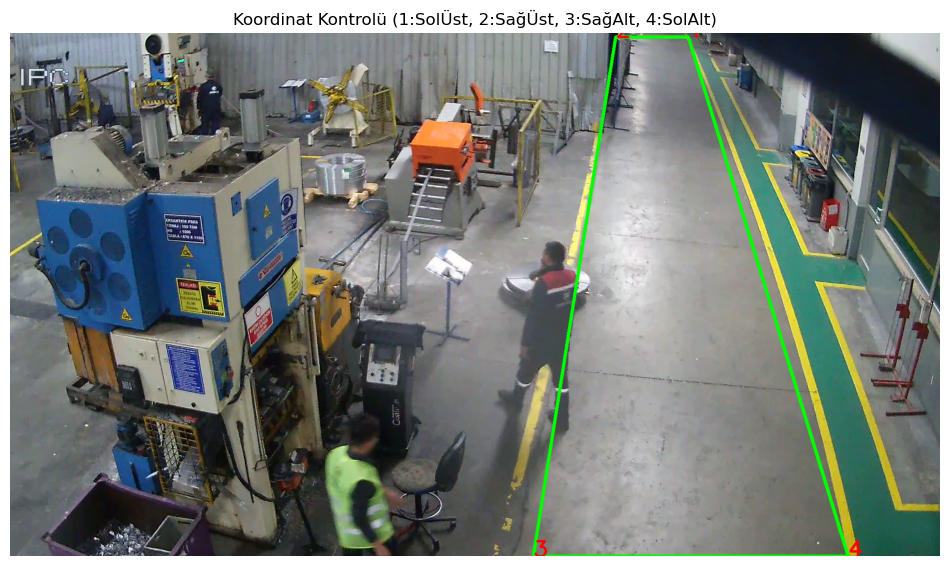

In [27]:
import zipfile
import tempfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- AYARLAR ---
zip_path = r"c:\Users\User\Desktop\fabrika\fab.zip"
# Düzeltildi: doğru dosya yolu (train klasöründeki 6_tr1.mp4)
member = "Video Dataset for Safe and Unsafe Behaviours/Safe and Unsafe Behaviours Dataset/train/6_closed_panel_cover/6_tr1.mp4"

# Buradaki sayıları değiştirerek deneme yap: [x, y]
# Sıralama: Sol-Üst, Sağ-Üst, Sağ-Alt, Sol-Alt
PANO_PTS = np.array([
    [1400, 10],  # Sol Üst
    [1250, 10],  # Sağ Üst
    [1080, 1080],  # Sağ Alt
    [1730, 1080]   # Sol Alt
], np.int32)

# 1. Videodan bir kareyi belleğe al
with zipfile.ZipFile(zip_path) as z:
    data = z.read(member)
    with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as tmp:
        tmp.write(data)
        tmp_path = tmp.name

cap = cv2.VideoCapture(tmp_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 30) # 30. kareyi görelim (pano netleşsin)
ret, frame = cap.read()
cap.release()
os.remove(tmp_path)

if ret:
    # 2. Koordinatları görsel üzerine çiz (Kontrol için)
    # Noktaları birleştirerek bir çokgen (polygon) çiziyoruz
    frame_vis = frame.copy()
    cv2.polylines(frame_vis, [PANO_PTS.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=5)
    
    # Köşelere numara yazalım (sıralamayı karıştırmamak için)
    for i, pt in enumerate(PANO_PTS):
        cv2.putText(frame_vis, str(i+1), tuple(pt), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

    # 3. Sonucu Göster
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
    plt.title("Koordinat Kontrolü (1:SolÜst, 2:SağÜst, 3:SağAlt, 4:SolAlt)")
    plt.axis('off')
    plt.show()
else:
    print("Video karesi okunamadı, yolu kontrol et.")


In [28]:
import cv2
import numpy as np
import os
from ultralytics import YOLO

# --- AYARLAR ---
VIDEO_PATH = "test_yetkili.mp4"
GREEN_RATIO_THRESHOLD = 0.05
PERSON_CONF = 0.30

# İhlal Bölgesi Koordinatları (Yaya Geçişi Yasak Yol)
YASAK_YOL_PTS = np.array([
    [1400, 10],    # Sol Üst
    [1250, 10],    # Sağ Üst
    [1080, 1080],  # Sağ Alt
    [1730, 1080]   # Sol Alt
], np.int32)

# Kayıt Klasörü Oluşturma
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
ihlal_path = os.path.join(desktop, "ihlal")
if not os.path.exists(ihlal_path):
    os.makedirs(ihlal_path)

model = YOLO('yolov8n.pt') 

# Hafıza Yönetimi
authorized_ids = set() 
person_history = {}    
last_boxes = {}        
next_id = 1

cap = cv2.VideoCapture(VIDEO_PATH)
w, h = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter('ihlal_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (w, h))

def check_green_locally(person_img):
    if person_img is None or person_img.size == 0: return False
    img_h, img_w = person_img.shape[:2]
    upper = person_img[int(img_h*0.1):int(img_h*0.45), :]
    hsv = cv2.cvtColor(upper, cv2.COLOR_BGR2HSV)
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    return (np.sum(mask > 0) / mask.size) > GREEN_RATIO_THRESHOLD

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # İhlal Bölgesini Videoda Görselleştir (Şeffaf Kırmızı Alan)
    overlay = frame.copy()
    cv2.fillPoly(overlay, [YASAK_YOL_PTS], (0, 0, 255))
    cv2.addWeighted(overlay, 0.2, frame, 0.8, 0, frame)

    results = model.predict(frame, conf=PERSON_CONF, imgsz=640, classes=[0], verbose=False)
    current_frame_ids = []
    
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2 # Merkez
            foot_pos = (cx, y2) # İhlal kontrolü için ayak basılan yer önemlidir
            
            # --- MANUEL ID TAKİBİ ---
            assigned_id = None
            min_dist = 80 
            for pid, last_pos in person_history.items():
                dist = np.sqrt((cx - last_pos[0])**2 + (cy - last_pos[1])**2)
                if dist < min_dist:
                    assigned_id = pid
                    min_dist = dist
                    break
            
            if assigned_id is None:
                assigned_id = next_id
                next_id += 1
            
            person_history[assigned_id] = (cx, cy)
            last_boxes[assigned_id] = (x1, y1, x2, y2)
            current_frame_ids.append(assigned_id)

            # Yetki kontrolü
            if assigned_id not in authorized_ids:
                crop = frame[max(0, y1):min(h, y2), max(0, x1):min(w, x2)]
                if check_green_locally(crop):
                    authorized_ids.add(assigned_id)

            # --- İHLAL KONTROLÜ (POINT IN POLYGON) ---
            # Kişinin ayak ucu yasak alanın içinde mi?
            is_in_yasak_bolge = cv2.pointPolygonTest(YASAK_YOL_PTS, (float(foot_pos[0]), float(foot_pos[1])), False)
            
            if is_in_yasak_bolge >= 0: # 0 çizgide, 1 içerde demektir
                # İstersen sadece yetkisizler (Kırmızı) ihlal yapsın diyebilirsin:
                # if assigned_id not in authorized_ids:
                
                # İhlal fotoğrafını kaydet
                file_name = f"ihlal_id_{assigned_id}_f_{frame_idx}.jpg"
                save_path = os.path.join(ihlal_path, file_name)
                cv2.imwrite(save_path, frame)
                
                # Ekrana İhlal Yazısı
                cv2.putText(frame, "!!! IHLAL: YASAK YOL !!!", (50, 100), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 4)

    # --- ÇİZİM AŞAMASI ---
    for pid in list(last_boxes.keys()):
        if pid in current_frame_ids:
            x1, y1, x2, y2 = last_boxes[pid]
            is_auth = pid in authorized_ids
            color = (0, 255, 0) if is_auth else (0, 0, 255)
            label = f"ID:{pid} {'YETKILI' if is_auth else 'PERSONEL'}"
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
            cv2.rectangle(frame, (x1, y1 - 25), (x1 + 150, y1), color, -1)
            cv2.putText(frame, label, (x1 + 5, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    out.write(frame)
    frame_idx += 1
    
    if len(person_history) > 30:
        active_ids = set(current_frame_ids)
        person_history = {k: v for k, v in person_history.items() if k in active_ids}
        last_boxes = {k: v for k, v in last_boxes.items() if k in active_ids}

cap.release()
out.release()
print(f"✅ İşlem bitti. İhlal kareleri Masaüstü/ihlal klasörüne kaydedildi.")

✅ İşlem bitti. İhlal kareleri Masaüstü/ihlal klasörüne kaydedildi.


In [30]:
import cv2
import numpy as np
import os
from ultralytics import YOLO

# --- AYARLAR ---
VIDEO_PATH = "test_yetkili.mp4"
GREEN_RATIO_THRESHOLD = 0.05
PERSON_CONF = 0.50

# İhlal Bölgesi Koordinatları
YASAK_YOL_PTS = np.array([
    [1400, 10],    # Sol Üst
    [1250, 10],    # Sağ Üst
    [1080, 1080],  # Sağ Alt
    [1730, 1080]   # Sol Alt
], np.int32)

# Kayıt Klasörü
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
ihlal_path = os.path.join(desktop, "ihlal")
if not os.path.exists(ihlal_path):
    os.makedirs(ihlal_path)

model = YOLO('yolov8n.pt') 

# Hafıza Yönetimi
authorized_ids = set() 
person_history = {}    
last_boxes = {}        
ihlal_yapan_idlar = set() # !!! YENİ: Sadece 1 kez kayıt almak için
next_id = 1

cap = cv2.VideoCapture(VIDEO_PATH)
w, h = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter('akilli_ihlal_denetim.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (w, h))

def check_green_locally(person_img):
    if person_img is None or person_img.size == 0: return False
    img_h, img_w = person_img.shape[:2]
    upper = person_img[int(img_h*0.1):int(img_h*0.45), :]
    hsv = cv2.cvtColor(upper, cv2.COLOR_BGR2HSV)
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    return (np.sum(mask > 0) / mask.size) > GREEN_RATIO_THRESHOLD

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # Görselleştirme için bölge çizimi
    overlay = frame.copy()
    cv2.fillPoly(overlay, [YASAK_YOL_PTS], (0, 0, 255))
    cv2.addWeighted(overlay, 0.2, frame, 0.8, 0, frame)

    results = model.predict(frame, conf=PERSON_CONF, imgsz=640, classes=[0], verbose=False)
    current_frame_ids = []
    
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            foot_pos = (cx, y2)
            
            # --- MANUEL ID TAKİBİ ---
            assigned_id = None
            min_dist = 80 
            for pid, last_pos in person_history.items():
                dist = np.sqrt((cx - last_pos[0])**2 + (cy - last_pos[1])**2)
                if dist < min_dist:
                    assigned_id = pid
                    min_dist = dist
                    break
            
            if assigned_id is None:
                assigned_id = next_id
                next_id += 1
            
            person_history[assigned_id] = (cx, cy)
            last_boxes[assigned_id] = (x1, y1, x2, y2)
            current_frame_ids.append(assigned_id)

            if assigned_id not in authorized_ids:
                crop = frame[max(0, y1):min(h, y2), max(0, x1):min(w, x2)]
                if check_green_locally(crop):
                    authorized_ids.add(assigned_id)

            # --- AKILLI İHLAL KONTROLÜ ---
            is_in_area = cv2.pointPolygonTest(YASAK_YOL_PTS, (float(foot_pos[0]), float(foot_pos[1])), False)
            
            if is_in_area >= 0:
                # Ekranda uyarıyı her zaman göster
                cv2.putText(frame, "!!! YASAK BOLGE !!!", (x1, y2 + 20), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                
                # SADECE DAHA ÖNCE KAYDEDİLMEMİŞSE FOTOĞRAF ÇEK
                if assigned_id not in ihlal_yapan_idlar:
                    file_name = f"ID_{assigned_id}_ilk_ihlal.jpg"
                    save_path = os.path.join(ihlal_path, file_name)
                    cv2.imwrite(save_path, frame)
                    ihlal_yapan_idlar.add(assigned_id) # Bu ID artık kaydedildi
                    print(f"📸 ID {assigned_id} için ilk ihlal karesi kaydedildi.")

    # --- ÇİZİM ---
    for pid in list(last_boxes.keys()):
        if pid in current_frame_ids:
            x1, y1, x2, y2 = last_boxes[pid]
            is_auth = pid in authorized_ids
            color = (0, 255, 0) if is_auth else (0, 0, 255)
            label = f"ID:{pid} {'YETKILI' if is_auth else 'PERSONEL'}"
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
            cv2.rectangle(frame, (x1, y1 - 25), (x1 + 150, y1), color, -1)
            cv2.putText(frame, label, (x1 + 5, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    out.write(frame)
    frame_idx += 1
    
    if len(person_history) > 30:
        active_ids = set(current_frame_ids)
        person_history = {k: v for k, v in person_history.items() if k in active_ids}
        last_boxes = {k: v for k, v in last_boxes.items() if k in active_ids}

cap.release()
out.release()
print("✅ İşlem bitti. Her ID için sadece tek bir ihlal karesi alındı.")

📸 ID 4 için ilk ihlal karesi kaydedildi.
✅ İşlem bitti. Her ID için sadece tek bir ihlal karesi alındı.
